In [1]:
# nn
import jax
from jax import numpy as jnp
from flax import nnx
import optax
from tensorflow import keras

# type annotations and functions
from functools import partial
import typing as tp
import math
import chex

# data manipulatin and visualization
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
import cv2

from utils import (
    _init_metrics_hisory,
    Accuracy,
    MLP,
    batch
)

In [2]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
idx_to_augment = np.random.randint(0, train_images.shape[0], 15000)
img_aug = train_images[idx_to_augment]
labels_aug = train_labels[idx_to_augment]

flip = keras.layers.RandomFlip("horizontal_and_vertical")
rotate = keras.layers.RandomRotation(0.2)
for i in range(len(img_aug)):
    aug_type = np.random.random()
    if aug_type > 0.5:
        img_aug[i] = flip(np.expand_dims(img_aug[i], axis=-1)).numpy().squeeze()
    else:
        img_aug[i] = rotate(np.expand_dims(img_aug[i], axis=-1)).numpy().squeeze()

train_images = np.concatenate((train_images, img_aug), axis=0)
train_labels = np.concatenate((train_labels, labels_aug), axis=0)

In [4]:
idx_to_augment = np.random.randint(0, test_images.shape[0], 1000)
img_aug = test_images[idx_to_augment]
labels_aug = test_labels[idx_to_augment]

for i in range(len(img_aug)):
    aug_type = np.random.random()
    if aug_type > 0.5:
        img_aug[i] = flip(np.expand_dims(img_aug[i], axis=-1)).numpy().squeeze()
    else:
        img_aug[i] = rotate(np.expand_dims(img_aug[i], axis=-1)).numpy().squeeze()

test_images = np.concatenate((test_images, img_aug), axis=0)
test_labels = np.concatenate((test_labels, labels_aug), axis=0)

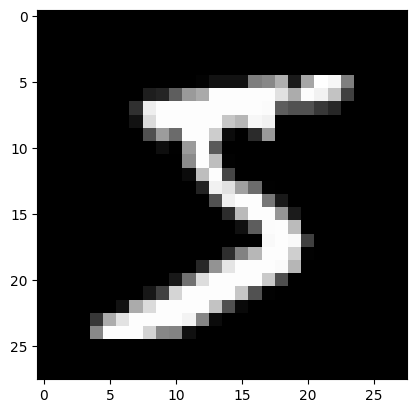

5


In [5]:
plt.imshow(train_images[0], cmap="grey")
plt.show()
print(train_labels[0])

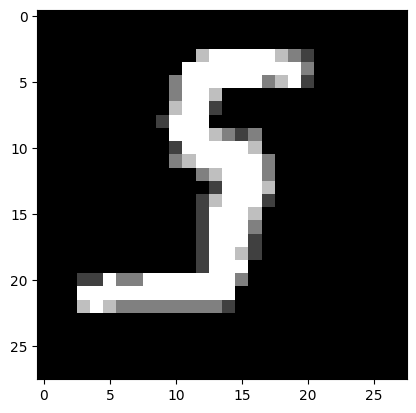

5


In [6]:
plt.imshow(train_images[60002], cmap="grey")
plt.show()
print(train_labels[60002])

In [7]:
train_images = train_images / 255
test_images = test_images / 255

In [8]:
class FlattenedMLP(MLP):
    """Simple MLP with variable hidden layers' size
    
    Args:
        - input_dim (int) - num of input features. Default: 60
        - hidden (tuple[int]) - optional sizes of hidden layers. Default: None
        - output_dim (int) - num of output features. Default: 10
        - rngs (nnx.Rngs) - random generator.
    
    Example:
    >>> import jax.numpy as jnp
    >>> from flax import nnx
    >>> model = MLP(input_dim=60, hidden=(5,), output_dim=10, rngs=nnx.Rngs(42))
    >>> y = jnp.ones(60)
    >>> model(y)
    Array([0.1900208], dtype=float32)
    """

    def __call__(self, x: chex.Array) -> chex.Array:
        x = x.flatten()
        x = self.nn(x)
        return x    
    
    
class ImageClassifier(nnx.Module):
    """Image Classifier with convolution layers for MNIST
    
    Args:
        - rngs (nnx.Rngs) - random generator.
    
    Example:
    >>> import jax.numpy as jnp
    >>> from flax import nnx
    >>> model = ImageClassifier(rngs=nnx.Rngs(42))
    >>> y = jnp.ones((28, 28, 1))
    >>> model(y)
    Array([-0.04220704,  0.03935139,  0.01222464,  0.1371675 , -0.05824947,
           -0.00577586, -0.00873756,  0.24104787, -0.13278076, -0.01037526],      dtype=float32)
    """
    def __init__(self, rngs: tp.Optional[nnx.Rngs] = None) -> None:
        if rngs is None:
            rngs = nnx.Rngs(42)

        self.cnn1 = nnx.Conv(1, 16, (3,3), rngs=rngs)
        self.cnn2 = nnx.Conv(16, 32, (3,3), padding='VALID', rngs=rngs)
        self.cnn3 = nnx.Conv(32, 16, (3,3), rngs=rngs)
        
        self.avg_pooling = partial(nnx.avg_pool, window_shape=(2,2), strides=(2,2))

        self.linear = nnx.Linear(144, 64, rngs=rngs)
        self.clf = nnx.Linear(64, 10, rngs=rngs)

        self.act = nnx.swish

    
    def __call__(self, x: chex.Array) -> chex.Array:
        # [28, 28, 1] -> [28, 28, 16] -> [14, 14, 16]
        x = self.avg_pooling(self.act(self.cnn1(x)))
        # [14, 14, 16] -> [12, 12, 32] -> [6, 6, 32]
        x = self.avg_pooling(self.act(self.cnn2(x)))
        # [6, 6, 32] -> [6, 6, 16] -> [3, 3, 16]
        x = self.avg_pooling(self.act(self.cnn3(x)))
        # [3, 3, 16] -> [144]
        x = x.flatten()
        x = self.act(self.linear(x))
        x = self.clf(x)
        return x
    

In [35]:
@nnx.jit # only now profitable
def loss_fn(model: tp.Union[MLP, ImageClassifier],
            features: chex.ArrayBatched, 
            labels: chex.ArrayBatched) -> tuple[chex.ArrayBatched]:
    """Computes CE-Loss with optax. Returns loss and logits"""
    
    logits = nnx.vmap(model)(features)
    loss = jnp.mean(
        optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=labels
        )
    )
    return loss, logits


@partial(jax.jit, static_argnums=0)
def train_step(graphdef: nnx.GraphDef, 
               state: nnx.GraphState,   
               features: chex.ArrayBatched, 
               labels: chex.ArrayBatched) -> nnx.GraphState:
    """Train for a single step."""
    model, optimizer, metrics = nnx.merge(graphdef, state)
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, features, labels)
    metrics.update(loss=loss, logits=logits, labels=labels)
    optimizer.update(grads)
    _, state = nnx.split((model, optimizer, metrics))
    return state


@partial(jax.jit, static_argnums=0)
def eval_step(graphdef: nnx.GraphDef, 
              state: nnx.GraphState,   
              features: chex.ArrayBatched,
              labels: chex.ArrayBatched) -> nnx.GraphState:
    """Eval for single step"""
    model, optimizer, metrics = nnx.merge(graphdef, state)
    loss, logits = loss_fn(model, features, labels)
    metrics.update(loss=loss, logits=logits, labels=labels)
    _, state = nnx.split((model, optimizer, metrics))
    return state


In [33]:
def run(X_train: chex.ArrayNumpy,
        y_train: chex.ArrayNumpy,
        X_test: chex.ArrayNumpy,
        y_test: chex.ArrayNumpy,
        model: tp.Union[MLP, ImageClassifier],
        batch_size: int = 8,
        key: tp.Optional[chex.PRNGKey] = None,
        num_epochs: int = 10) -> tuple[tp.Union[MLP, ImageClassifier], dict[str, chex.Array], nnx.State, nnx.State]:
    """Inits model and it's components and run train and test"""
    if key is None:
        key = jax.random.key(42)
    batch_key = jax.random.split(key)[0]
    # get model and default weights of the first layer
    optimizer = nnx.Optimizer(model, optax.adamw(5e-3, 0.9))
    metrics_history = _init_metrics_hisory()
    metrics = nnx.MultiMetric(
        accuracy=Accuracy(),
        loss=nnx.metrics.Average('loss'),
    )

    for i in range(num_epochs):
        # train
        model.train()
        graphdef, state = nnx.split((model, optimizer, metrics))

        # new order for shuffle
        batch_key = jax.random.split(batch_key)[0]
        for X_batched, y_batched in batch(X=X_train,
                                          y=y_train,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=True):
            state = train_step(graphdef=graphdef,
                               state=state,
                               features=X_batched,
                               labels=y_batched)

        # if flax >= 0.10.0
        # nnx.update((model, optimizer, metrics), state)

        # else
        model, optimizer, metrics = nnx.merge(graphdef, state)
        # store train metrics
        for metric, value in metrics.compute().items():     
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        # eval
        model.eval()
        graphdef, state = nnx.split((model, optimizer, metrics))
        for X_batched, y_batched in batch(X=X_test,
                                          y=y_test,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=False):
            state = eval_step(graphdef=graphdef,
                             state=state,
                             features=X_batched, 
                             labels=y_batched)
        
        # if flax >= 0.10.0
        # nnx.update((model, optimizer, metrics), state)
        
        # else
        model, optimizer, metrics = nnx.merge(graphdef, state)
        # store eval metrics
        for metric, value in metrics.compute().items():    
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset() 

        print(
            f"[train] eposh: {i}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] epoch: {i}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )
    
    return model, metrics_history


In [11]:
model = FlattenedMLP(input_dim=28*28, 
                     hidden=(256,), 
                     output_dim=10,
                     rngs=nnx.Rngs(42))

In [12]:
trained_mlp, metrics_history = run(X_train=train_images, 
                                   y_train=train_labels, 
                                   X_test=test_images, 
                                   y_test=test_labels,
                                   model=model,
                                   batch_size=125,
                                   key=jax.random.key(42),
                                   num_epochs=10)

[train] eposh: 0, loss: 0.34272241592407227, accuracy: 89.51866912841797
[test] epoch: 0, loss: 0.14873529970645905, accuracy: 95.4454574584961
[train] eposh: 1, loss: 0.1623435765504837, accuracy: 95.01333618164062
[test] epoch: 1, loss: 0.13170558214187622, accuracy: 95.85454559326172
[train] eposh: 2, loss: 0.11590994149446487, accuracy: 96.34666442871094
[test] epoch: 2, loss: 0.15467728674411774, accuracy: 95.65454864501953
[train] eposh: 3, loss: 0.09269726276397705, accuracy: 97.02266693115234
[test] epoch: 3, loss: 0.14252163469791412, accuracy: 95.85454559326172
[train] eposh: 4, loss: 0.07457534223794937, accuracy: 97.55733489990234
[test] epoch: 4, loss: 0.14617206156253815, accuracy: 96.32727813720703
[train] eposh: 5, loss: 0.06400306522846222, accuracy: 97.86933135986328
[test] epoch: 5, loss: 0.18371300399303436, accuracy: 95.63636016845703
[train] eposh: 6, loss: 0.059816475957632065, accuracy: 98.02400207519531
[test] epoch: 6, loss: 0.1591157466173172, accuracy: 96.21

In [30]:
model = ImageClassifier(rngs=nnx.Rngs(42))
y = jnp.ones((28, 28, 1))
model(y)

Array([-0.04220704,  0.03935139,  0.01222464,  0.1371675 , -0.05824947,
       -0.00577586, -0.00873756,  0.24104787, -0.13278076, -0.01037526],      dtype=float32)

In [37]:
trained_cnn, metrics_history, *_ = run(X_train=np.expand_dims(train_images, axis=-1), 
                                       y_train=train_labels, 
                                       X_test=np.expand_dims(test_images, axis=-1), 
                                       y_test=test_labels,
                                       model=model,
                                       batch_size=125,
                                       key=jax.random.key(42),
                                       num_epochs=5)

[train] eposh: 0, loss: 0.36246049404144287, accuracy: 89.06266784667969
[test] epoch: 0, loss: 0.102608822286129, accuracy: 96.84545135498047
[train] eposh: 1, loss: 0.12750084698200226, accuracy: 95.97332763671875
[test] epoch: 1, loss: 0.0810973271727562, accuracy: 97.43636322021484
[train] eposh: 2, loss: 0.09069305658340454, accuracy: 97.13333129882812
[test] epoch: 2, loss: 0.060367777943611145, accuracy: 98.08181762695312


KeyboardInterrupt: 

In [15]:
# # DOES NOT WORK, NO ORBAX ON WINDOWS

# import orbax.checkpoint as ocp

# ckpt_dir = ocp.test_utils.erase_and_create_empty('./ckpt/')
# checkpointer = ocp.StandardCheckpointer()

# _, state = nnx.split(trained_cnn)
# checkpointer.save(ckpt_dir / "state", state)

# abs_model = nnx.eval_shape(lambda: ImageClassifier(nnx.Rngs(0)))
# graphdef, abs_state = nnx.split(abs_model)

# state_restored = checkpointer.restore(ckpt_dir / 'state', abs_state)
# jax.tree.map(np.testing.assert_array_equal, state, state_restored)
# model = nnx.merge(graphdef, state_restored)

In [16]:
# # DOES NOT WORK AS INTENDED, NO SPEED UP !!!
# # MAYBE WORTH TESTING ON GPU/TPU

# import time

# @nnx.jit
# def re_loss_fn(model, data):
#         features, labels = data
#         logits = nnx.vmap(model)(features)
#         loss = jnp.mean(jax.vmap(
#             optax.softmax_cross_entropy_with_integer_labels)
#             (logits=logits, labels=labels)
#         )

#         return loss, logits


# def re_train_step(graph, state, data):
#     nn, opt, metrics = nnx.merge(graph, state)
#     _, labels = data
#     (loss, logits), grad = nnx.value_and_grad(re_loss_fn, has_aux=True)(nn, data)
#     metrics.update(loss=loss, logits=logits, labels=labels)
    
#     opt.update(grad)
#     # graph, state = nnx.split((model, opt, metrics))
#     return nnx.split((model, opt, metrics))

# def re_run(X_train: chex.ArrayNumpy,
#         y_train: chex.ArrayNumpy,
#         model: tp.Union[MLP, ImageClassifier],
#         batch_size: int = 8,
#         key: tp.Optional[chex.PRNGKey] = None,
#         num_epochs: int = 10) -> tuple[tp.Union[MLP, ImageClassifier], dict[str, chex.Array], nnx.State, nnx.State]:
    
#     if key is None:
#         key = jax.random.key(42)
#     batch_key = jax.random.split(key)[0]
#     # get model and default weights of the first layer
#     optimizer = nnx.Optimizer(model, optax.adamw(5e-3, 0.9))
#     metrics_history = _init_metrics_hisory()
#     metrics = nnx.MultiMetric(
#         accuracy=Accuracy(),
#         loss=nnx.metrics.Average('loss'),
#     )
#     X_train = jnp.array(X_train)
#     y_train = jnp.array(y_train)
    

#     train_multiple_steps_with_idxs = (
#         lambda gr, st, dat, idxs: nnx.scan(
#             lambda st, idxs: (st, re_train_step(gr, st, jax.tree.map(lambda a: a[idxs], dat)))
#         )(st, idxs)
#     )
#     model.train()
#     for i in range(num_epochs):
#         graphdef, state = nnx.split((model, optimizer, metrics))
#         order = jax.random.permutation(batch_key, len(y_train)).reshape(-1, batch_size)
#         start = time.time()
#         foo, (graphdef, state) = train_multiple_steps_with_idxs(graphdef, state, (X_train, y_train), order)
#         print(time.time() - start)

#         model, optimizer, metrics = nnx.merge(graphdef, state)
#         # store train metrics
#         for metric, value in metrics.compute().items():     
#             metrics_history[f'train_{metric}'].append(value)
#         metrics.reset()

#         print(
#             f"[train] eposh: {i}, "
#             f"loss: {metrics_history['train_loss'][-1]}, "
#             f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
#         )
    
#     return model, metrics_history

# test_model = FlattenedMLP(input_dim=28*28, 
#                      hidden=(256,), 
#                      output_dim=10,
#                      rngs=nnx.Rngs(42))

# _, metrics_history = re_run(X_train=train_images, 
#                                    y_train=train_labels, 
#                                    model=test_model,
#                                    batch_size=125,
#                                    key=jax.random.key(42),
#                                    num_epochs=10)


In [17]:
def get_best_shift(img: np.ndarray) -> tuple[np.int64]:
    cy, cx = center_of_mass(img)
    
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty
  
def shift(img: np.ndarray, sx: np.int64, sy: np.int64) -> np.ndarray:
    rows,cols = img.shape
    M = np.float32([[1, 0, sx],[0, 1, sy]])
    shifted = cv2.warpAffine(img, M, (cols, rows))
    return shifted
  
def rec_digit(model: tp.Union[MLP, ImageClassifier], 
              img_path: str) -> None:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gray = 255 - img
    # threshholding
    _, gray = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # cutting edges
    while np.sum(gray[0]) == 0:
        gray = gray[1:]
    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)
    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]
    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)
    rows,cols = gray.shape
    
    # resize number to 20*20
    if rows > cols:
        factor = 20.0 / rows
        rows = 20
        cols = int(round(cols * factor))
        gray = cv2.resize(gray, (cols, rows))
    else:
        factor = 20.0 / cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows))

    # resize with padding
    colsPadding = (int(math.ceil((28 - cols) / 2.0)), int(math.floor((28 - cols) / 2.0)))
    rowsPadding = (int(math.ceil((28 - rows) / 2.0)), int(math.floor((28 - rows) / 2.0)))
    gray = np.lib.pad(gray, (rowsPadding, colsPadding), 'constant')

    # centering
    shiftx,shifty = get_best_shift(gray)
    shifted = shift(gray,shiftx,shifty)
    gray = shifted
    
    img = gray / 255.0
    plt.imshow(img, cmap="gray")
    print(np.argmax(model(np.expand_dims(img, axis=-1))))

2


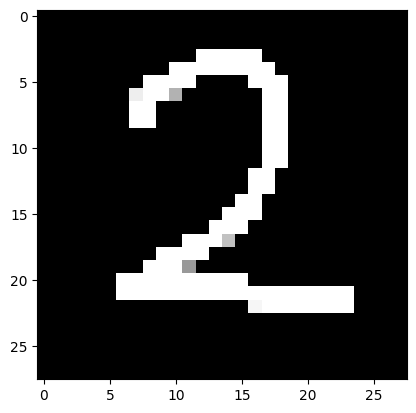

In [18]:
rec_digit(trained_cnn, "../img/2.png")

5


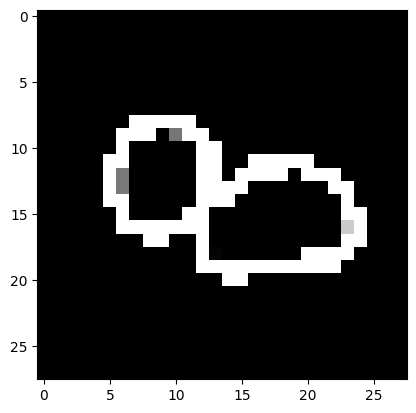

In [19]:
rec_digit(trained_cnn, "../img/8.png")

8


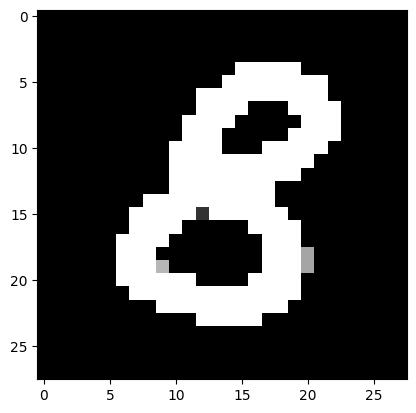

In [20]:
rec_digit(trained_cnn, "../img/8_2.png")

1


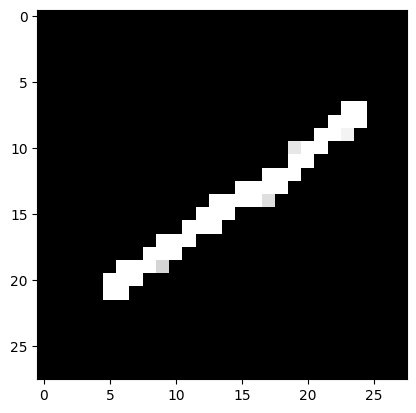

In [21]:
rec_digit(trained_cnn, "../img/1.png")

4


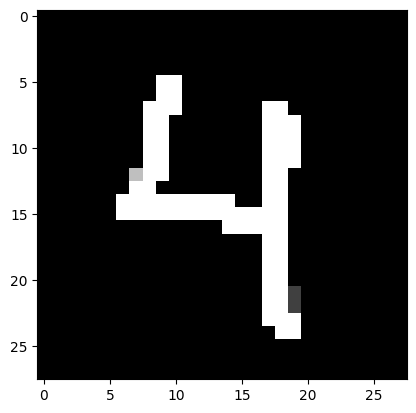

In [22]:
rec_digit(trained_cnn, "../img/4.png")

8


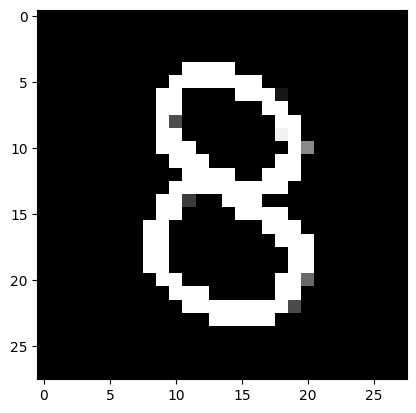

In [23]:
rec_digit(trained_cnn, "../img/draw.png")